In [ ]:
# Colab cell 1: Setup & Imports

!pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Image Acquisition and Preprocessing Pipeline

This cell handles automated downloading of the content and style images from external URLs. It also defines a helper function to load, resize, normalize, and batch the images using standard ImageNet transformation parameters. Both content and style images are preprocessed and moved to the selected computation device for further use in the model.


In [ ]:
import urllib.request
from PIL import Image
from torchvision import transforms

def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = in_transform(image).unsqueeze(0)
    return image.to(device)

content_url = 'https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg'
style_url = 'https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg'

content_path = '/content/content.jpg'
style_path = '/content/style.jpg'

urllib.request.urlretrieve(content_url, content_path)
urllib.request.urlretrieve(style_url, style_path)

print("Images downloaded successfully.")

content = load_image(content_path).to(device)
style = load_image(style_path, shape=content.shape[-2:]).to(device)

print("Content and Style images loaded and preprocessed.")

Images downloaded successfully.
Content and Style images loaded and preprocessed.


# Neural Style Transfer Using VGG19 Features

This cell implements the core of the Neural Style Transfer process using a pre-trained VGG19 model as a fixed feature extractor. Specific convolutional layers are selected to extract content and style representations from the input images. The target image, initialized as a clone of the content image, is optimized iteratively to minimize a weighted combination of content and style losses. The style is captured via Gram matrices, while content similarity is preserved through mean squared error over selected feature maps.

In [ ]:
import copy

vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad = False

content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def get_features(image, model, layers):
    features = {}
    x = image
    layer_names = {
        '0': 'conv1_1', '5': 'conv2_1',
        '10': 'conv3_1', '19': 'conv4_1',
        '21': 'conv4_2', '28': 'conv5_1'
    }
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layer_names:
            layer_name = layer_names[name]
            if layer_name in layers:
                features[layer_name] = x
    return features

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

target = content.clone().requires_grad_(True).to(device)

style_weight = 1e6
content_weight = 1

optimizer = optim.Adam([target], lr=0.003)

steps = 200

for step in range(steps):
    target_features = get_features(target, vgg, content_layers + style_layers)
    content_features = get_features(content, vgg, content_layers)
    style_features = get_features(style, vgg, style_layers)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        layer_style_loss = torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / len(style_layers)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Total loss: {total_loss.item():.4f}")

print("Style transfer complete!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.6MB/s]


Step 0, Total loss: 69216208158720.0000
Step 50, Total loss: 21873955962880.0000
Step 100, Total loss: 8234184212480.0000
Step 150, Total loss: 3204212064256.0000
Style transfer complete!


# Output Visualization and Postprocessing

This cell prepares the final output image for visualization by reversing the normalization applied during preprocessing. A helper function denormalizes the tensor and converts it into a displayable RGB image. The content, style, and the generated stylized output are rendered side-by-side using Matplotlib to clearly demonstrate the effectiveness of style transfer.



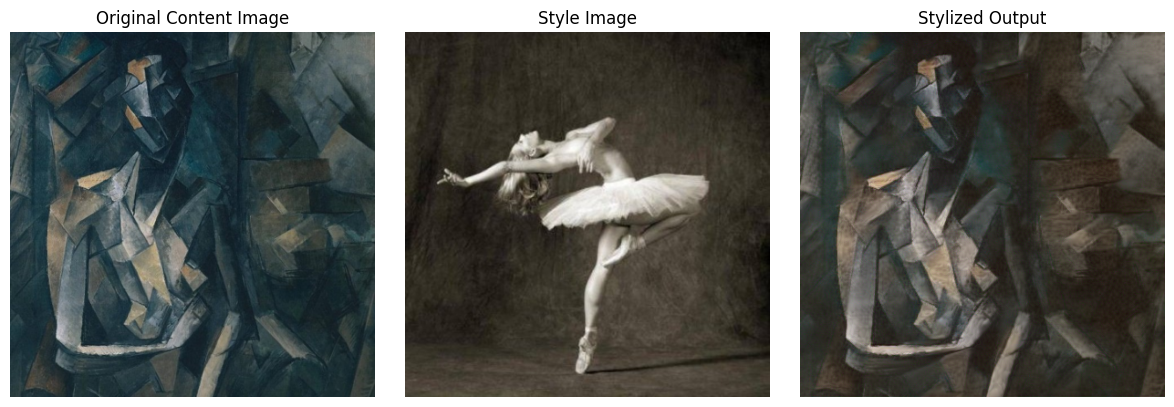

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    tensor = tensor.clone().detach()
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    tensor = tensor.clamp(0, 1)
    return tensor

def show_all_images(content, style, output):
    images = [content, style, output]
    titles = ['Original Content Image', 'Style Image', 'Stylized Output']

    plt.figure(figsize=(12, 4))
    for i in range(3):
        img = denormalize(images[i].squeeze())
        img = img.cpu().permute(1, 2, 0).numpy()
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_all_images(content, style, target)

# Save and Download the Stylized Output Image

This final utility cell handles the post-processing and export of the stylized output image. After denormalizing the generated tensor back to a valid image format, it is saved to the local Colab environment and instantly made available for download to the user's machine. This step ensures the results of the neural style transfer are portable and accessible outside the notebook.




In [ ]:

from torchvision.utils import save_image
from google.colab import files

output_path = '/content/output_styled_image.jpg'
save_image(denormalize(target).cpu(), output_path)
print(f"Output image saved at {output_path}")

files.download(output_path)

Output image saved at /content/output_styled_image.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Text-to-Image Generation Using Stable Diffusion

This cell demonstrates the integration of the Stable Diffusion v1.5 pipeline to generate high-quality, AI-synthesized images from a textual prompt. The Hugging Face diffusers library is leveraged here for inference.
The cell includes optimizations like silent package installations, suppression of warnings and progress bars for a clutter-free experience, and a compact, borderless visualization. The generated image is also saved locally for persistence.



Keyword arguments {'use_auth_token': None} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

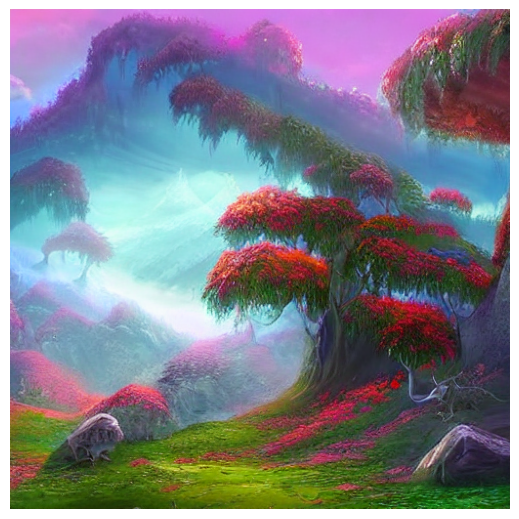

In [ ]:
!pip install -q diffusers transformers accelerate scipy safetensors matplotlib > /dev/null

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    use_auth_token=None
).to(device)

prompt = "a beautiful fantasy landscape, digital art"
image = pipe(prompt).images[0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

image.save("generated_image.png")

# Multi-Image Synthesis with Prompt Repetition

In this cell, we extend the Stable Diffusion pipeline to generate multiple variations of an image from the same textual prompt. This helps visualize the model's generative diversity and interpret how differently it can perceive and synthesize the same concept. The results are displayed in a neat 2×2 grid using matplotlib, with each image titled for clarity.
The generated images are also saved locally with distinct filenames for offline use and further analysis.

  0%|          | 0/50 [00:00<?, ?it/s]

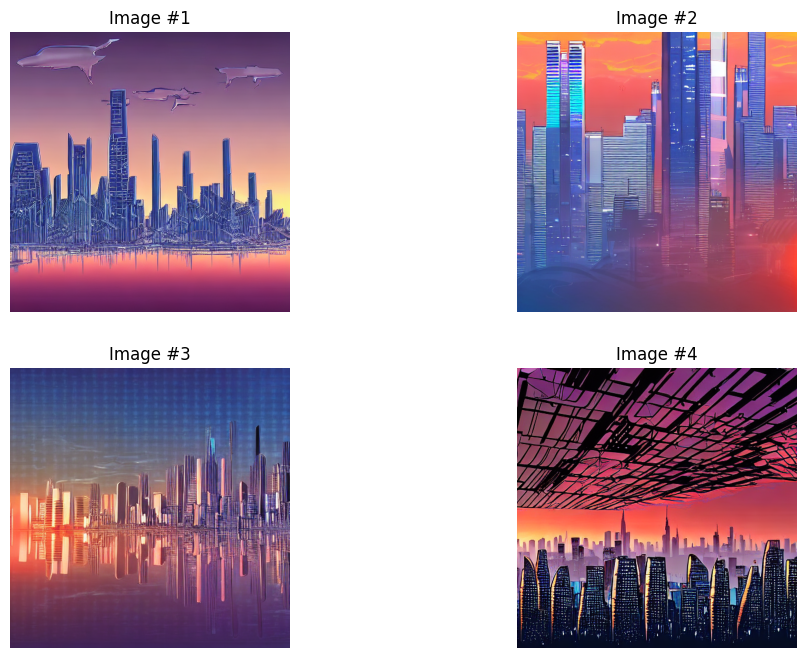

In [ ]:
import matplotlib.pyplot as plt

prompt = "a futuristic city skyline at sunset, digital art"
num_images = 4

images = pipe([prompt]*num_images).images

plt.figure(figsize=(12, 8))

for i, img in enumerate(images):
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image #{i+1}")

plt.show()

for i, img in enumerate(images):
    img.save(f"generated_image_{i+1}.png")

# High-Resolution Image Generation (768×768) via Stable Diffusion

This cell demonstrates controlled generation of high-resolution images (768×768) using the StableDiffusionPipeline. By explicitly setting the height and width parameters, the model synthesizes visually richer and more detailed outputs suited for applications requiring upscale imagery. The generated image is displayed and saved locally for further usage.



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

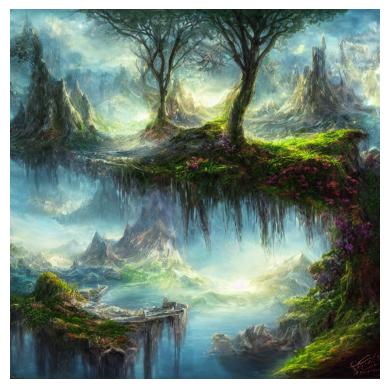

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if device=="cuda" else torch.float32)
pipe = pipe.to(device)

prompt = "a beautiful fantasy landscape, digital art"

image = pipe(prompt, height=768, width=768).images[0]

plt.imshow(image)
plt.axis('off')
plt.show()

image.save("high_res_generated_image.png")

# Prompt-Based Multi-Image Generation and Visualization

This section generates multiple distinct images from the same prompt to assess the generative variability of the Stable Diffusion model. The prompt is passed repeatedly to the pipeline, and each output is visualized in a compact 2×2 grid. This technique is particularly useful for evaluating the model’s creative range and consistency under identical input conditions.

Each image is also optionally saved to disk for further use.

  0%|          | 0/50 [00:00<?, ?it/s]

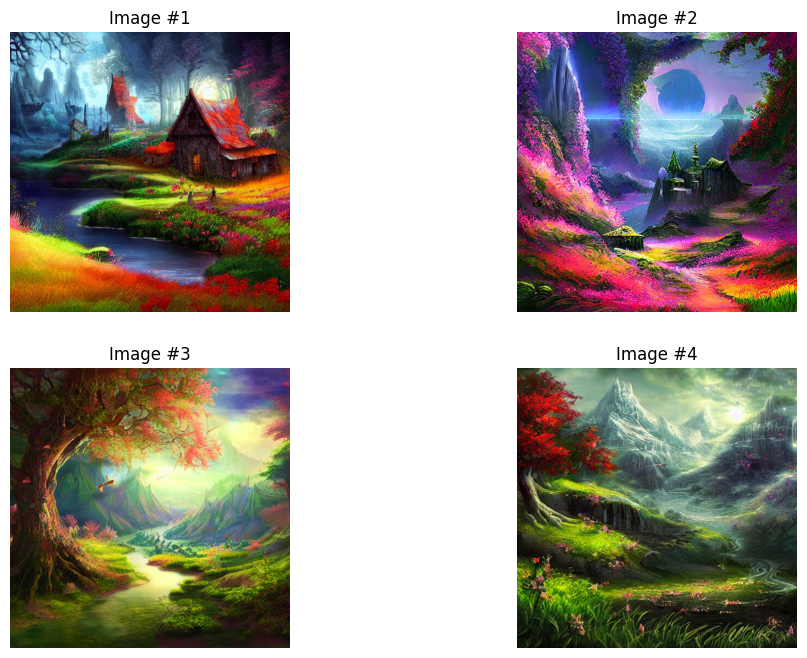

In [ ]:
import matplotlib.pyplot as plt

prompt = "a beautiful fantasy landscape, digital art"
num_images = 4

images = pipe([prompt]*num_images).images

plt.figure(figsize=(12, 8))

for i, img in enumerate(images):
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image #{i+1}")

plt.show()

for i, img in enumerate(images):
    img.save(f"generated_image_{i+1}.png")


# Controlled Image Generation using Manual Seeding

This cell demonstrates how to generate deterministic and reproducible outputs by manually setting different random seeds using PyTorch's Generator. Each image is conditioned on the same prompt but with a unique seed, allowing for a controlled variation in outputs.

By varying the seed, we explore how the generative model interprets the same concept differently under fixed randomness, which is useful for content exploration and comparative evaluation.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

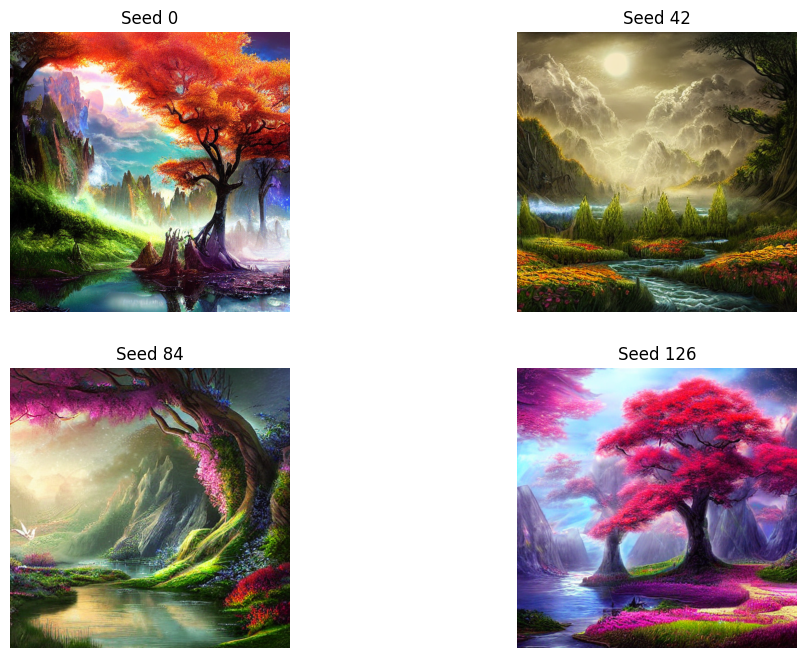

In [ ]:
import torch
import matplotlib.pyplot as plt

prompt = "a beautiful fantasy landscape, digital art"
num_images = 4

plt.figure(figsize=(12, 8))

for i in range(num_images):
    generator = torch.Generator(device).manual_seed(i*42)
    image = pipe(prompt, generator=generator).images[0]
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Seed {i*42}")

plt.show()

# CLIP-Based Prompt Similarity Evaluation

In this final cell, we evaluate the semantic alignment between the generated image and the original text prompt using the CLIP (Contrastive Language-Image Pretraining) model from OpenAI.

CLIP maps both text and image into a shared embedding space, and computes a similarity score between them. This helps in quantifying how well the image reflects the intended concept described in the prompt.

We use clip-vit-base-patch32 for this task and report:

    Raw similarity score (dot product in embedding space)

    Softmax probability (confidence of alignment)

This step is essential when you want to automatically evaluate generation quality without human intervention.

In [ ]:
!pip install -q transformers ftfy regex

from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def clip_score(image, text):
    inputs = processor(text=[text], images=image, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    return logits_per_image.item(), probs[0][0].item()

prompt = "a beautiful fantasy landscape, digital art"
score, prob = clip_score(image, prompt)
print(f"CLIP similarity score: {score:.4f}")
print(f"CLIP similarity probability: {prob:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP similarity score: 30.0234
CLIP similarity probability: 1.0000


# Prompt-Wise CLIP Evaluation Dashboard

Each prompt is used to:

    Generate an image using Stable Diffusion

    Evaluate similarity with CLIP

    Store and visualize the results

We show a score table and a bar chart to compare how well each generated image aligns with its prompt.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Evaluation Results Table

Prompt  CLIP Score  CLIP Probability
0  a beautiful fantasy landscape, digital art   33.945049               1.0
1          a futuristic city, cyberpunk style   33.283077               1.0
2            a cute puppy playing in the park   29.182261               1.0
3         an astronaut riding a horse on Mars   36.199005               1.0
4           a serene mountain lake at sunrise   30.872869               1.0

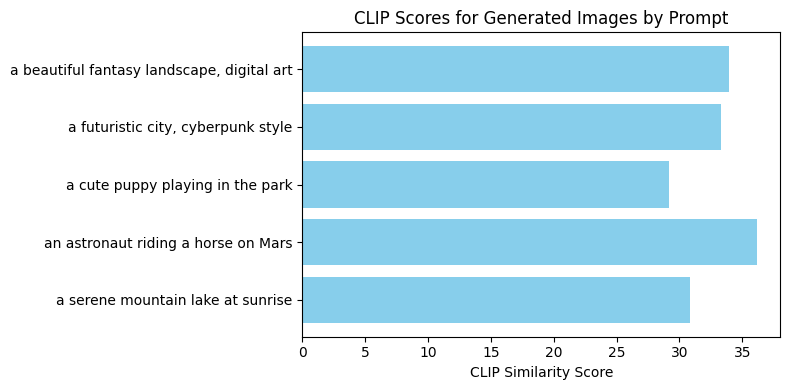

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

prompts = [
    "a beautiful fantasy landscape, digital art",
    "a futuristic city, cyberpunk style",
    "a cute puppy playing in the park",
    "an astronaut riding a horse on Mars",
    "a serene mountain lake at sunrise"
]

results = []

for p in prompts:
    img = pipe(p).images[0]
    score, prob = clip_score(img, p)
    results.append({"Prompt": p, "CLIP Score": score, "CLIP Probability": prob})

df = pd.DataFrame(results)

from IPython.display import display, Markdown

display(Markdown("### Evaluation Results Table"))
display(df)

print("\n\n")

plt.figure(figsize=(8,4))
plt.barh(df['Prompt'], df['CLIP Score'], color='skyblue')
plt.xlabel("CLIP Similarity Score")
plt.title("CLIP Scores for Generated Images by Prompt")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()